# Project 2: Regression Challenge

## Problem Statement
---

Property website PropertyGoroUSA, would like to add a Sale Price prediction function for the Ames, Iowa market.
Where their agents can have an estimate sale price of the properties listed on their website.
To do that we will be looking at what features of a house are most important in predicting its price in the Ames, Iowa market? Would a linear regression model be developed that achieves RMSE error of ~30K?

## Executive Summary
---

In this notebook, we will be using the Ames, Iowa Housing Dataset retrieved from [Kaggle](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/data). 
<br>The dataset consist of 2 files, train.csv and test.csv. 
<br>The target variable in this dataset is SalePrice.
<br>This notebook will be boardly organised as below:

### Contents:
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)
- [Conclusions](#Conclusions)

## Data Import and Cleaning
---

In [1]:
# Importing modules used in this notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, median_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV

#setting options for both pandas and numpy to show decimals up to 4 places
pd.set_option('display.precision',4)
np.set_printoptions(precision=4)
%precision 4
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
# Defining a dict to hold the filenames.
# Reason for this is for the ease of changing the filenames and path,
# without changing any other codes
data_files = {
    'train' : '../data/train.csv',
    'test' : '../data/test.csv',
    'submit' : '../data/submission.csv',
    'data_dict' : '../data/data_dictionary.csv',
    'heatmap' : '../data/heatmap.png'
}

#### Code Naming Convention

To ensure clarity and ease of troubleshooting 
- **Training** data variables will be prefix with <font color=darkblue>**trn**</font> in the variable names
- **Test** data variables will be prefix with <font color=darkblue>**tst**</font> in the variable names

In [4]:
# Load both train and test date from csv file
trn_df = pd.read_csv(data_files['train'])
tst_df = pd.read_csv(data_files['test'])

In [5]:
display(trn_df.head(2))
display(tst_df.head(2))

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  

[2 rows x 81 columns]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0   NaN          NaN        0       4     2006        WD   
1   NaN          NaN        0       8     2006        WD   

[2 rows x 80 columns]

In [6]:
print(f'shape of train data: {trn_df.shape[0]} rows by {trn_df.shape[1]} columns')
print(f'shape of test data:  {tst_df.shape[0]} rows by {tst_df.shape[1]} columns')

shape of train data: 2051 rows by 81 columns
shape of test data:  879 rows by 80 columns


In [7]:
# Checking for missing column between trn_df and tst_df
np.setdiff1d(trn_df.columns, tst_df.columns)
# Confirmed that test dataset doesn't have a SalePrice column 

array(['SalePrice'], dtype=object)

In [8]:
# Checking if the Id columns in both Train and Test are unique
print(f'Id column in train data is unique: {pd.Series(trn_df["Id"]).is_unique}')
print(f'Id column in test data is unique: {pd.Series(tst_df["Id"]).is_unique}')

Id column in train data is unique: True
Id column in test data is unique: True


Setting the Id column as the index, since both columns hold unique values.

In [9]:
# Set the 'Id' column as the index
trn_df.set_index('Id', inplace=True);
tst_df.set_index('Id', inplace=True);

In [10]:
# Removing the space in the column names and setting to lowercase
trn_df.columns = trn_df.columns.str.replace(' ', '').str.lower()
tst_df.columns = tst_df.columns.str.replace(' ', '').str.lower()

### Analysing Target variable 'saleprice'
---

In [11]:
# Looking at the description of saleprice
display(trn_df['saleprice'].describe())
print(f"saleprice, Skew is: {trn_df['saleprice'].skew():.4f}")
print(f"saleprice, Kurtosis: {trn_df['saleprice'].kurt():.4f}")

count      2051.0000
mean     181469.7016
std       79258.6594
min       12789.0000
25%      129825.0000
50%      162500.0000
75%      214000.0000
max      611657.0000
Name: saleprice, dtype: float64

saleprice, Skew is: 1.5576
saleprice, Kurtosis: 3.5790


Looking at saleprice's information, nothing out of the ordinary. <br>
Next let's look at saleprice in a plot, the distribution is skewed to the right with relatively small spread.

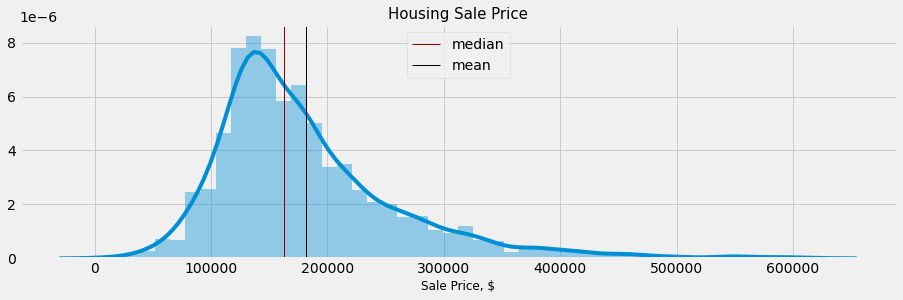

In [12]:
# Plotting saleprice
plt.figure(figsize=(14,4))
sns.distplot(trn_df['saleprice']);
plt.title('Housing Sale Price', fontsize=15)
plt.xlabel('Sale Price, $', fontsize=12);
plt.axvline(trn_df['saleprice'].median(), label="median", color='darkred', linewidth=1)
plt.axvline(trn_df['saleprice'].mean(), label="mean", color='k', linewidth=1)
plt.legend(loc='upper center');

In the Data documentation's special notes section, it's mentioned that there are 5 observations that are recomeded to be removed.<br> Let's look into this, plotting **grlivarea** against **saleprice** for train data we do see 2 outliers. <br> As this outliers maybe skew our prediction, these 2 observations will be dropped. <br>
The other 3 outliers are in the test data, but will be leaving those alone.

grlivarea  saleprice
Id                        
1499       5642     160000
2181       5095     183850

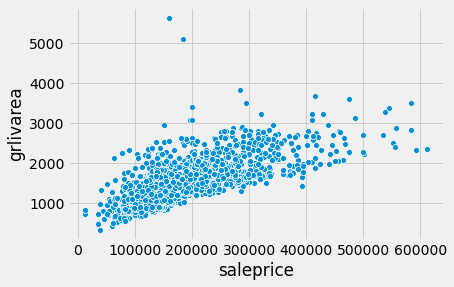

In [13]:
# plotting grlivarea against saleprice for train data
sns.scatterplot(trn_df['saleprice'], trn_df['grlivarea'])
trn_df[trn_df['grlivarea']>4000][['grlivarea', 'saleprice']]

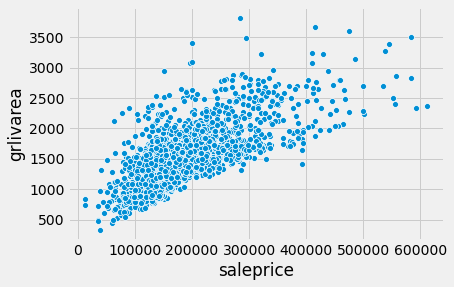

In [14]:
trn_df = trn_df[trn_df['grlivarea']<=4000]
# checking the plot after removing the outliers
sns.scatterplot(trn_df['saleprice'], trn_df['grlivarea']);

### Analysing the rest of the features
---

In this section, we will be looking into the rest of the features in our training data. <br>
To ensure a systemic and accurate analysis, firstly the data dictionary from Kaggle has be converted into a csv file. <br> Additional information has been added as well for checks and analysis<br>
Next a function has be created to compare the training data against the data dictionary.

In [15]:
# Load data dictionary from csv file
dict_df = pd.read_csv(data_files['data_dict'])

#### Data dictionary for the csv file that is holding Kaggle's Data Dictionary

After studying the Data Dictionary on Kaggle, this is the data dictionary converted into a csv file with additonal columns that will help with analysis of both the training and test datasets. 

| Column | Name        | Data Type | Description                                                                                                                                        |
|:-------:|:------------|:---------:|:---------------------------------------------------------------------------------------------------------------------------------------------------|
| 0      | name        | str       | Name of the feature                                                                                                                               |
| 1      | description | str       | Description of the feature                                                                                                                         |
| 2      | datatype    | str       | Data type for the feature, this is not in Kaggle. Added for analysis of the data. |
| 3      | vartype     | str       | Variable type for the feature, there are 23 Ordinal, 22 Norminal, 19 Continuous and 14 Discrete. |
| 4      | min         | numeric   | Minimum value for the feature, this is not in Kaggle. Added for checking out of range values. NaN if this check is not required for this feature.  |
| 5      | max         | numeric   | Maximum value for the feature, this is not in Kaggle. Added for checking out of range values. NaN if this check is not required for this feature.  |
| 6      | values      | str       | Value list for the categorical data feature. Added for checking unique values. Each value is '\|' delimited and NaN if this check is not required. |
| 7      | convert     | str       | python dictionary for converting ordinal features to numeric values |

In [16]:
dict_df.head()

name                                        description  \
0          pid                       Parcel identification number   
1   mssubclass                                The building class    
2     mszoning  Identifies the general zoning classification o...   
3  lotfrontage        Linear feet of street connected to property   
4      lotarea                            Lot size in square feet   

      datatype     vartype  min  max  \
0      numeric     Nominal  NaN  NaN   
1  categorical     Nominal  NaN  NaN   
2  categorical     Nominal  NaN  NaN   
3      numeric  Continuous  0.0  NaN   
4      numeric  Continuous  0.0  NaN   

                                              values convert  
0                                                NaN     NaN  
1  20|30|40|45|50|60|70|75|80|85|90|120|150|160|1...     NaN  
2                               A|C|FV|I|RH|RL|RP|RM     NaN  
3                                                NaN     NaN  
4                                                NaN     NaN

#### Function definations for data check and cleanup

In [17]:
# Function to get single value from DataFrame
def get_val(df, row, col):
    """ 
    Function to copmare data dictionary against dataframe
  
    Parameters: 
		df (DataFrame): DataFrame that is holding the data
        row (str): DataFrame row value as string
        col (str): DataFrame column value as string
  
    Returns: 
		Value from DataFrame     
  
    """
    return df.loc[df['name']==row, col].values[0]

In [18]:
# Function to check unique values from feature against data dictionary
def chk_unique(df, d_df, col):
    """ 
    Function to check unique values from feature against data dictionary
  
    Parameters: 
		df (DataFrame): DataFrame that is holding the data
        d_df (DataFrame): Data Dictionary DataFrame
        col (str): DataFrame column value as string
  
    Returns: 
		Empty list when there is no difference or when there is difference 
        List of consisting of a list of different values and a message str
  
    """
    # check the unique values against data dictionary
    dd_val = get_val(d_df, col, 'values').split('|')
    diff = set(df[col].unique()).difference(set(dd_val))
    if len(diff):
        msg = f'col: [{col}] no. of unique difference:{len(diff)} diff:<{diff}>\n'
        return [list(diff), msg]
    else:
        return []

In [19]:
# Function to check data dictionary against dataframe
def data_dict_check(df, dict_df, debug=False):
    """ 
    Function to check target DataFrame against Data Dictionary for discrepancy
    The checks are:
        1) datatypes are consistent with the data dictionary
        2) values are not below the minimum
        3) values are not above the maximum
        4) for catergorical data check that the values matches the dictionary
  
    Parameters: 
		df (DataFrame): Target DataFrame to be checked against Data Dictionary
        dict_df (DataFrame): DataFrame holding the data dictionary 
  
    Returns: 
		dictionary: returns a dictionary of errors found      
  
    """
    # init dictionary to hold findings
    result = {
        'dtype' : [], # List of dtype errors
        'min' : {}, # list of min errors
        'max' : {}, # list of max errors
        'unique' : {}, # dict of col with unique issue
        
    }
    
    for col in df.columns:
        msg=''
        # skip for pid and saleprice
        if col=='pid' or col=='saleprice':
            continue
        
        dd_dtype = get_val(dict_df, col, 'datatype')
        # check if column dataype is numeric
        if np.issubdtype(df[col].dtype, np.number):
            if dd_dtype=='numeric':
                # check for values below min
                dd_min = get_val(dict_df, col, 'min')
                if not pd.isna(dd_min):
                    if df[col].min()<int(dd_min):
                        result['min'][col]=df[col].min()
                        msg = msg + f'col: [{col}] has values below min. min[{df[col].min()}]\n'
                # check for values above max
                dd_max = get_val(dict_df, col, 'max')
                if not pd.isna(dd_max):
                    if df[col].max()>int(dd_max):
                        result['max'][col]=df[col].max()
                        msg = msg + f'col: [{col}] has values above max. max[{df[col].max()}]\n'
            else:
                result['dtype'].append(col)
                msg = msg + f'col: [{col}] datatype differ from Data Dictionary\n'
                msg = msg + f'col: [{col}] dtype:{df[col].dtype} != dict:{dd_dtype}'
        else:
            if dd_dtype=='categorical':
                # check the unique values against data dictionary
                chk_result = chk_unique(df, dict_df, col)
                if len(chk_result):
                    result['unique'][col]=chk_result[0]
                    msg = msg + chk_result[1]
            else:
                result['dtype'].append(col)
                msg = msg + f'col: [{col}] datatype differ from Data Dictionary\n'
                msg = msg + f'col: [{col}] dtype:{df[col].dtype} != dict:{dd_dtype}'
        
        if len(msg) and debug:
            print('\n-------------------------------------------------')
            print(f'{msg}')
        
        
    return result

In [20]:
# running the analysis for both train and test data
trn_result = data_dict_check(trn_df, dict_df)
tst_result = data_dict_check(tst_df, dict_df)

#### Looking into Datatype difference

In [21]:
print(f"dtype difference for train data are: {trn_result['dtype']}")
print(f"dtype difference for test data are: {tst_result['dtype']}")

dict_df[dict_df['name'].isin(trn_result['dtype'])][['name', 'vartype']]

dtype difference for train data are: ['mssubclass', 'overallqual', 'overallcond']
dtype difference for test data are: ['mssubclass', 'overallqual', 'overallcond']


name  vartype
1    mssubclass  Nominal
17  overallqual  Ordinal
18  overallcond  Ordinal

These 3 features are categorical, however the categories are numeric thus they have been loaded into the dataframe as numerical features. <br> Will be converting **mssubclass** feature into a string column as keeping they as numeric may cause ranking to be applied to this feature,<br> when the feature is not ordinal. Will be leaving **overallqual** and **overallcond** as numeric as both of these features are ordinal in nature.

In [22]:
# changing all the values in mssubclass to str
trn_df['mssubclass'] = trn_df['mssubclass'].map(lambda x: str(x))
display(trn_df['mssubclass'].dtypes)

tst_df['mssubclass'] = tst_df['mssubclass'].map(lambda x: str(x))
display(tst_df['mssubclass'].dtypes)

dtype('O')

dtype('O')

---
#### Looking into the out of range values

In [23]:
# checking min and max results
print(f"Train features with values less than min are: {trn_result['min'].keys()}")
print(f"Train features with values more than max are: {trn_result['max'].keys()}\n")
print(f"Test features with values less than min are: {tst_result['min'].keys()}")
print(f"Test features with values more than max are: {tst_result['max'].keys()}")

Train features with values less than min are: dict_keys([])
Train features with values more than max are: dict_keys(['garageyrblt'])

Test features with values less than min are: dict_keys([])
Test features with values more than max are: dict_keys([])


Not values were below minimum, which is good. 
However we do have value that is above maximum, investigating into this next.
Checking **garageyrblt**, against the other year features.
Looks to be a typo, so will be correcting the value to **2007**.

In [24]:
# check garageyrblt against the other year values
trn_df[trn_df['garageyrblt']==trn_result['max']['garageyrblt']][['yearbuilt', 'yearremod/add', 'garageyrblt', 'yrsold']]

yearbuilt  yearremod/add  garageyrblt  yrsold
Id                                                 
2261       2006           2007       2207.0    2007

In [25]:
# updating the value and validate change is successful
trn_df.loc[2261, 'garageyrblt']=2007
trn_df.loc[2261][['yearbuilt', 'yearremod/add', 'garageyrblt', 'yrsold']]

yearbuilt        2006
yearremod/add    2007
garageyrblt      2007
yrsold           2007
Name: 2261, dtype: object

---
#### Looking into the unique values mismatch

For now we will filter out the features that are different due to NaN, these NaN features will be looked into in the next section. <br> As the errors/typos are consistent on both Train and Test we will take note for now and leave these as is. 

In [26]:
# Train data
# filter out those that are different due to NaN
trn_uniq = { key:val for key, val in trn_result['unique'].items() if str(val[0])!='nan' }
trn_uniq

{'mszoning': ['I (all)', 'C (all)', 'A (agr)'],
 'neighborhood': ['NAmes'],
 'bldgtype': ['Duplex', 'Twnhs', '2fmCon'],
 'exterior2nd': ['Wd Shng', 'Brk Cmn', 'CmentBd'],
 'saletype': ['WD ']}

In [27]:
# Train data
# for these features the difference can easier be mapped back to a correct value in the dictionary
trn_df['mszoning'].replace({'A (agr)': 'A', 'C (all)': 'C', 'I (all)': 'I'}, inplace=True)
trn_df['neighborhood'].replace({'NAmes': 'Names'}, inplace=True)
trn_df['exterior2nd'].replace({'Brk Cmn': 'BrkComm', 'Wd Shng': 'Wd Sdng', 'CmentBd': 'CemntBd'}, inplace=True)
trn_df['saletype'].replace({'WD ': 'WD'}, inplace=True)
# For this feature, assumation is made that Twnhs is TwnhsE since there are values for TwnhsI
trn_df['bldgtype'].replace({'Duplex': 'Duplx', '2fmCon': '2FmCon', 'Twnhs': 'TwnhsE'}, inplace=True)

In [28]:
# Quick confirmation on the changes made
[ chk_unique(trn_df, dict_df, k) for k in trn_uniq.keys() ]

[[], [], [], [], []]

In [29]:
# Test data
# filter out those that are different due to NaN
tst_uniq = { key:val for key, val in tst_result['unique'].items() if str(val[0])!='nan' }
tst_uniq

{'mszoning': ['I (all)', 'C (all)'],
 'neighborhood': ['NAmes'],
 'bldgtype': ['Duplex', 'Twnhs', '2fmCon'],
 'exterior2nd': ['Wd Shng', 'Brk Cmn', 'CmentBd'],
 'saletype': ['WD ']}

In [30]:
# Test data
# making the same changes on the test data
tst_df['mszoning'].replace({'C (all)': 'C', 'I (all)': 'I'}, inplace=True)
tst_df['neighborhood'].replace({'NAmes': 'Names'}, inplace=True)
tst_df['exterior2nd'].replace({'Brk Cmn': 'BrkComm', 'Wd Shng': 'Wd Sdng', 'CmentBd': 'CemntBd'}, inplace=True)
tst_df['saletype'].replace({'WD ': 'WD'}, inplace=True)
tst_df['bldgtype'].replace({'Duplex': 'Duplx', '2fmCon': '2FmCon', 'Twnhs': 'TwnhsE'}, inplace=True)

In [31]:
# Quick confirmation on the changes made
[ chk_unique(tst_df, dict_df, k) for k in tst_uniq.keys() ]

[[], [], [], [], []]

---
#### Looking into features with missing values

In [32]:
# Function to find features with high NaN percentage
def find_nan_col(df, d_df, percent):
    """ 
    Function to find columns with high NaN percentage
  
    Parameters: 
		df (DataFrame): DataFrame that is holding the data
        d_df (DataFrame): Data Dictionary DataFrame
        percent (int): cutoff percent of NaN in the column 
  
    Returns: 
		List: List of column with NaN above the cutoff percent    
  
    """
    # Calculating the count and percentage of NaN Values of each colum
    nan_df = [(col, df[col].isna().sum(), 
               df[col].isna().mean()*100) for col in df]
    nan_df = pd.DataFrame(nan_df, 
                          columns=["col_name", "nan_count", 
                                   "nan_percent"]).set_index('col_name')
    nan_df['vartype'] = [ get_val(d_df, c, 'vartype') for c in nan_df.index.tolist() ]
    return nan_df[nan_df['nan_percent']>percent].sort_values('nan_percent', ascending=False)

Imputing for 80% of NaN wouldn't make sense and it'll impact the prediction outcomes. <br> Thus these features with more than 80% NaN will be dropped.

In [33]:
# Get list of columns with more than 80% NaN values
trn_nan_cols = find_nan_col(trn_df, dict_df, 80).index.tolist()
tst_nan_cols = find_nan_col(tst_df, dict_df, 80).index.tolist()
print(f'List of train data columns with more than 80% NaN are: {trn_nan_cols}')
print(f'List of test data columns with more than 80% NaN are: {tst_nan_cols}')

List of train data columns with more than 80% NaN are: ['poolqc', 'miscfeature', 'alley', 'fence']
List of test data columns with more than 80% NaN are: ['poolqc', 'miscfeature', 'alley', 'fence']


In [34]:
# As PoolQC, MiscFeature, Alley and Fence have more than 80% of NaN
# thus these columns will be dropped from the DataFrame
trn_df = trn_df.drop(trn_nan_cols, axis=1)
tst_df = tst_df.drop(tst_nan_cols, axis=1)

Moving on to the other columns with missing values

In [35]:
trn_nan_df = find_nan_col(trn_df, dict_df, 0)
tst_nan_df = find_nan_col(trn_df, dict_df, 0)

Start by looking at the NaN basement features as a group as they are related. <br>
After analysis of the basement features, bsmtexposure, bsmtfintype2, bsmtfintype1, bsmtcond and bsmtqual <br>
55 of the NaN values are because there is no basement. <br>

With the exception of: <br>
**bsmtexposure**, index 67, 1797 and 2780 where the basements are unfinished<br>
**bsmtfintype2**, index 445 NaN although the rest have values <br>

In [36]:
# Get the list of ordinal basement feature with NaN
mask = (trn_nan_df.index.str.contains('bsmt') & (trn_nan_df['vartype']=='Ordinal'))
bsmt_cols = trn_nan_df[mask].index.tolist()

In [37]:
# Filling the NaN values with 'NA' for No Basement
[ trn_df[col].fillna('NA', inplace=True) for col in bsmt_cols ]; # Train data
[ tst_df[col].fillna('NA', inplace=True) for col in bsmt_cols ]; # Test data

In [38]:
# Setting bsmtexposure to No as NA represents no basement that contradict the other columns
mask = ((trn_df['bsmtcond']!='NA') & (trn_df['bsmtexposure']=='NA'))
print(f"List of index for bsmtexposure set to 'No': {trn_df[mask][bsmt_cols].index.tolist()}")
for i in trn_df[mask][bsmt_cols].index.tolist():
    trn_df.loc[i, 'bsmtexposure']='No'

List of index for bsmtexposure set to 'No': [1797, 67, 2780]


In [39]:
# Updating bsmtfintype2 to 'GLQ' as the rest of the basement conditons are Good
mask = ((trn_df['bsmtcond']!='NA') & (trn_df['bsmtfintype2']=='NA'))
print(f"List of index for bsmtfintype2 set to 'No': {trn_df[mask][bsmt_cols].index.tolist()}")
for i in trn_df[mask][bsmt_cols].index.tolist():
    trn_df.loc[i, 'bsmtfintype2']='GLQ'

List of index for bsmtfintype2 set to 'No': [445]


For the rest of the basement features with NaN, these are coming from 2 entries.
Index 1342 and 1498, checked against the other basement feature and confirmed that there is no basement.
Therefore will be filling these NaN with 0

In [40]:
# Get the list of the other basement features with NaN
mask = (trn_nan_df.index.str.contains('bsmt') & (trn_nan_df['vartype']!='Ordinal'))
bsmt_cols = trn_nan_df[mask].index.tolist()

In [41]:
# Updating the other bsmt to 0
mask = ((trn_df['bsmtfullbath'].isna()))
print(f"List of index for the rest of the basement features set to 0: {trn_df[mask].index.tolist()}")
# Filling the NaN values with 0
[ trn_df[col].fillna(0, inplace=True) for col in bsmt_cols ]; # Train data
[ tst_df[col].fillna(0, inplace=True) for col in bsmt_cols ]; # Test data

List of index for the rest of the basement features set to 0: [1498, 1342]


Next group of NaN features to look at is garage features. <br>
After analysis these NaN were due to the fact that the house doesn't have a garage. <br>
Thus will be filling the categorical data with 'NA' and numeric data with 0

In [42]:
# Lambda function to return 'NA' or 0 depending on the vartype
fill = lambda col: 'NA' if get_val(dict_df, col, 'vartype') in ('Ordinal', 'Nominal') else 0

In [43]:
# Get the list of basement feature with NaN
mask = (trn_nan_df.index.str.contains('garage'))
g_cols = trn_nan_df[mask].index.tolist()
# filling NaN values with 0 or 'NA'
[ trn_df[col].fillna(fill(col), inplace=True) for col in g_cols ]; # Train data
[ tst_df[col].fillna(fill(col), inplace=True) for col in g_cols ]; # Test data

The last group that we look at will be Masonry veneer features. <br>
Similar to the garage the NaN are because the Masonry veneer is None.<br>
Thus will be filling the categorical data with 'None' and numeric data with 0

In [44]:
# Lambda function to return 'None' or 0 depending on the vartype
fill = lambda col: 'None' if get_val(dict_df, col, 'vartype') in ('Ordinal', 'Nominal') else 0

In [45]:
mv_cols=['masvnrtype', 'masvnrarea']
# filling NaN values with 0 or 'NA'
[ trn_df[col].fillna(fill(col), inplace=True) for col in mv_cols ]; # Train data
[ tst_df[col].fillna(fill(col), inplace=True) for col in mv_cols ]; # Test data

Looking into **fireplacequ** feature, similar to garage as well NaN are those houses without a fireplace. <br>
This is confirmed by checking against the **fireplaces** feature.

In [46]:
# filling in the NaN with 'NA'
trn_df['fireplacequ'].fillna('NA', inplace=True) # Train data
tst_df['fireplacequ'].fillna('NA', inplace=True) # Test data

Finally the **lotfrontage** feature with 330 NaN counts. <br>
Imputation will be using the mean of lotfrontage by lotshape and lotconfig.

In [47]:
# Get average of LotFrontage by LotShape and LotConfig in a DataFrame for lookup
# LotFrontage average for Train Data
trn_lf_ave = trn_df[~trn_df['lotfrontage'].isna()]\
                    .groupby(['lotshape', 'lotconfig'], as_index=False)\
                    .mean()[['lotshape', 'lotconfig', 'lotfrontage']]

# LotFrontage average for Test Data
tst_lf_ave = tst_df[~tst_df['lotfrontage'].isna()]\
                    .groupby(['lotshape', 'lotconfig'], as_index=False)\
                    .mean()[['lotshape', 'lotconfig', 'lotfrontage']]

In [48]:
# Lambda function to lookup and return average LotFrontage by LotShape and LotConfig
trn_lf = lambda ls, lc : float(round(trn_lf_ave.loc[(trn_lf_ave['lotshape']==ls) & (trn_lf_ave['lotconfig']==lc), 'lotfrontage']))

Doing a quick check if the imputed values will skew the distribution away from the original distribution

In [49]:
# Checking LotFrontage imputation
trn_lf_chk = trn_df[['pid', 'lotfrontage', 'lotshape', 'lotconfig']].copy()
trn_lf_chk['lf_imputed'] = trn_lf_chk['lotfrontage']

# Loop through LotFrontage with NaN, to assign average value 
for i, row in trn_lf_chk[trn_lf_chk['lf_imputed'].isna()].iterrows():
    trn_lf_chk.loc[trn_lf_chk['pid']==row['pid'], 'lf_imputed'] = trn_lf(row['lotshape'], row['lotconfig'])

In [50]:
print(f"Imputed-> mean: {trn_lf_chk['lf_imputed'].mean()}, median: {trn_lf_chk['lf_imputed'].median()}")
print(f"Original-> mean: {trn_lf_chk['lotfrontage'].mean()}, median: {trn_lf_chk['lotfrontage'].median()}")

Imputed-> mean: 69.24792581747194, median: 69.0
Original-> mean: 68.87899941826643, median: 68.0


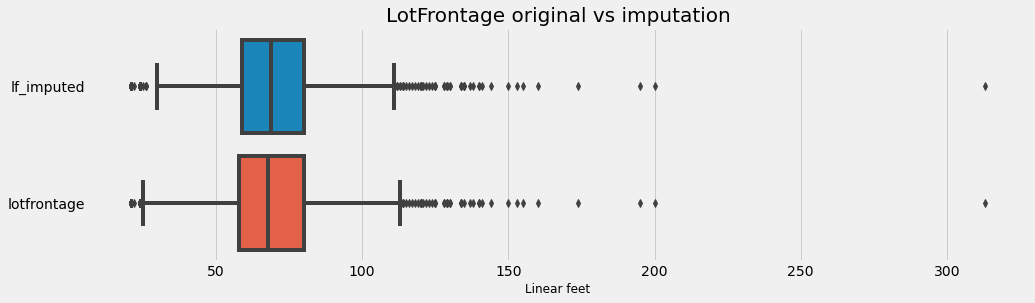

In [51]:
# Doing a comparison between the imputed and original
plt.figure(figsize=(15,4))
plt.title('LotFrontage original vs imputation', fontsize = 20)
plt.xlabel('Linear feet', fontsize = 12)
sns.boxplot(data=trn_lf_chk[['lf_imputed', 'lotfrontage']], orient='h');

Imputation doesn't change the distribution much, so will go ahead with this imputed values.

In [52]:
# Fixing LotFrontage for Train Data
# Loop through LotFrontage with NaN, to assign average value 
for i, row in trn_df[trn_df['lotfrontage'].isna()].iterrows():
    trn_df.loc[trn_df['pid']==row['pid'], 'lotfrontage'] = trn_lf(row['lotshape'], row['lotconfig'])

In [53]:
# Fixing LotFrontage for Test Data
# Lambda function to lookup and return average LotFrontage by LotShape and LotConfig
tst_lf = lambda ls, lc : float(round(tst_lf_ave.loc[(tst_lf_ave['lotshape']==ls) & (tst_lf_ave['lotconfig']==lc), 'lotfrontage']))

# Loop through LotFrontage with NaN, to assign average value 
for i, row in tst_df[tst_df['lotfrontage'].isna()].iterrows():
    tst_df.loc[tst_df['pid']==row['pid'], 'lotfrontage'] = tst_lf(row['lotshape'], row['lotconfig'])

Quick check on the test data shows that there is a NaN value for the **electrical** feature

In [54]:
# As it's only one NaN, will be setting it to mode of electrical
tst_df.loc[tst_df['electrical'].isna(), 'electrical'] = tst_df['electrical'].mode()[0]

---
#### Looking into ordinal features

In [55]:
# split the columns into 2 groups, categorical and numeric 
trn_obj_col = trn_df.select_dtypes(include=['object']).columns.tolist() # group of categorical columns
trn_num_col = trn_df.select_dtypes(exclude=['object']).columns.tolist() # group of numeric columns
trn_num_col.remove('pid')
trn_num_col.remove('saleprice')

Will be converting the ordinal features to natural numbers to keep the ranking. Assumption here is that these values are equally spaced. <br>
To facilitate the convertion, the replace dictionary has been added into the data dictionary reason is that when data change, no codes need to be changed just make the updates into the data dictionary csv file. 

In [56]:
# get a list of ordinal columns
ordinal_list = list(set(set(dict_df.query('vartype=="Ordinal"')['name'].tolist())).intersection(trn_obj_col))

# Converting the ordinal features to numeric, using the replace dictionary uploaded from csv 
[ trn_df[col].replace(eval(get_val(dict_df, col, 'convert')), inplace=True) for col in ordinal_list ]; # Train data
[ tst_df[col].replace(eval(get_val(dict_df, col, 'convert')), inplace=True) for col in ordinal_list ]; # Test data

## Exploratory Data Analysis
---
[top](#Executive-Summary)

In this section we will be looking further into the features' distribution and correlation to the target.

Before continuing with the analysis, will be adding some new features so that they can be compared against target as well as the other features.

In [57]:
# introducting new features
# age at point of sale
trn_df['age'] = trn_df['yrsold']-trn_df['yearbuilt']
tst_df['age'] = tst_df['yrsold']-tst_df['yearbuilt']

# remodel flag to track if the house has been remodeled
trn_df['remodel'] = (trn_df['yearbuilt']!=trn_df['yearremod/add']).astype(int)
tst_df['remodel'] = (tst_df['yearbuilt']!=tst_df['yearremod/add']).astype(int)

# garage flag to track if the house has a garage
trn_df['garage'] = (trn_df['garageyrblt']!=0).astype(int)
tst_df['garage'] = (tst_df['garageyrblt']!=0).astype(int)

# combining totalbsmtsf and grlivarea
trn_df['totalarea'] = trn_df['totalbsmtsf'] + trn_df['grlivarea']
tst_df['totalarea'] = tst_df['totalbsmtsf'] + tst_df['grlivarea']

In [58]:
# updating the numerical column list with the newly added columns
trn_num_col = trn_df.select_dtypes(exclude=['object']).columns.tolist() # group of numeric columns
trn_num_col = list(set(trn_num_col)-set(ordinal_list))
trn_num_col.remove('pid')
trn_num_col.remove('saleprice')

---
#### Analysis of continuous features against the target

In [59]:
# Function to plot multiple scatter plots.
def subplot_scatter(dataframe, col, list_of_col_pairs, list_of_titles, list_of_xlabels, list_of_ylabels):
    """ 
    Function to plot multiple scatter plots. 
  
    Parameters: 
		dataframe (Dateframe): Dateframe that is holding all the data
        list_of_col_pairs (list): List of columns pairs that are to be plotted in the scatter plot
        list_of_titles (list): List titles for the scatter plot
        list_of_xlabels (list): List of labels for the scatter plot's x-axis
        list_of_ylabels (list): List of labels for the scatter plot's y-axis
  
    Returns: 
		None  
  
    """
    nrows = int(np.ceil(len(list_of_col_pairs)/col)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=col, figsize=(20,6*nrows))
    ax = ax.ravel()

    for i, column in enumerate(list_of_col_pairs): 
        #ax[i].scatter(dataframe[column[0]], dataframe[column[1]])
        sns.regplot(x=column[0], y=column[1], data=dataframe, ax=ax[i])
        ax[i].set_title(list_of_titles[i], fontsize = 20)
        ax[i].set_ylabel(list_of_ylabels[i], fontsize = 12)
        ax[i].set_xlabel(list_of_xlabels[i], fontsize = 12)
        
        # apply Median lines
        ax[i].axvline(dataframe[column[0]].median(),\
                label=f'{list_of_xlabels[i]} Median', color='green', linestyle='--')
        ax[i].axhline(dataframe[column[1]].median(),\
                label=f'{list_of_ylabels[i]} Median', color='black', linestyle='-.')
    
    # delete the empty subplots
    if col!=len(list_of_col_pairs):
        for c in range(col - len(list_of_col_pairs)%col):
            fig.delaxes(ax[(c+1)*-1])
    return

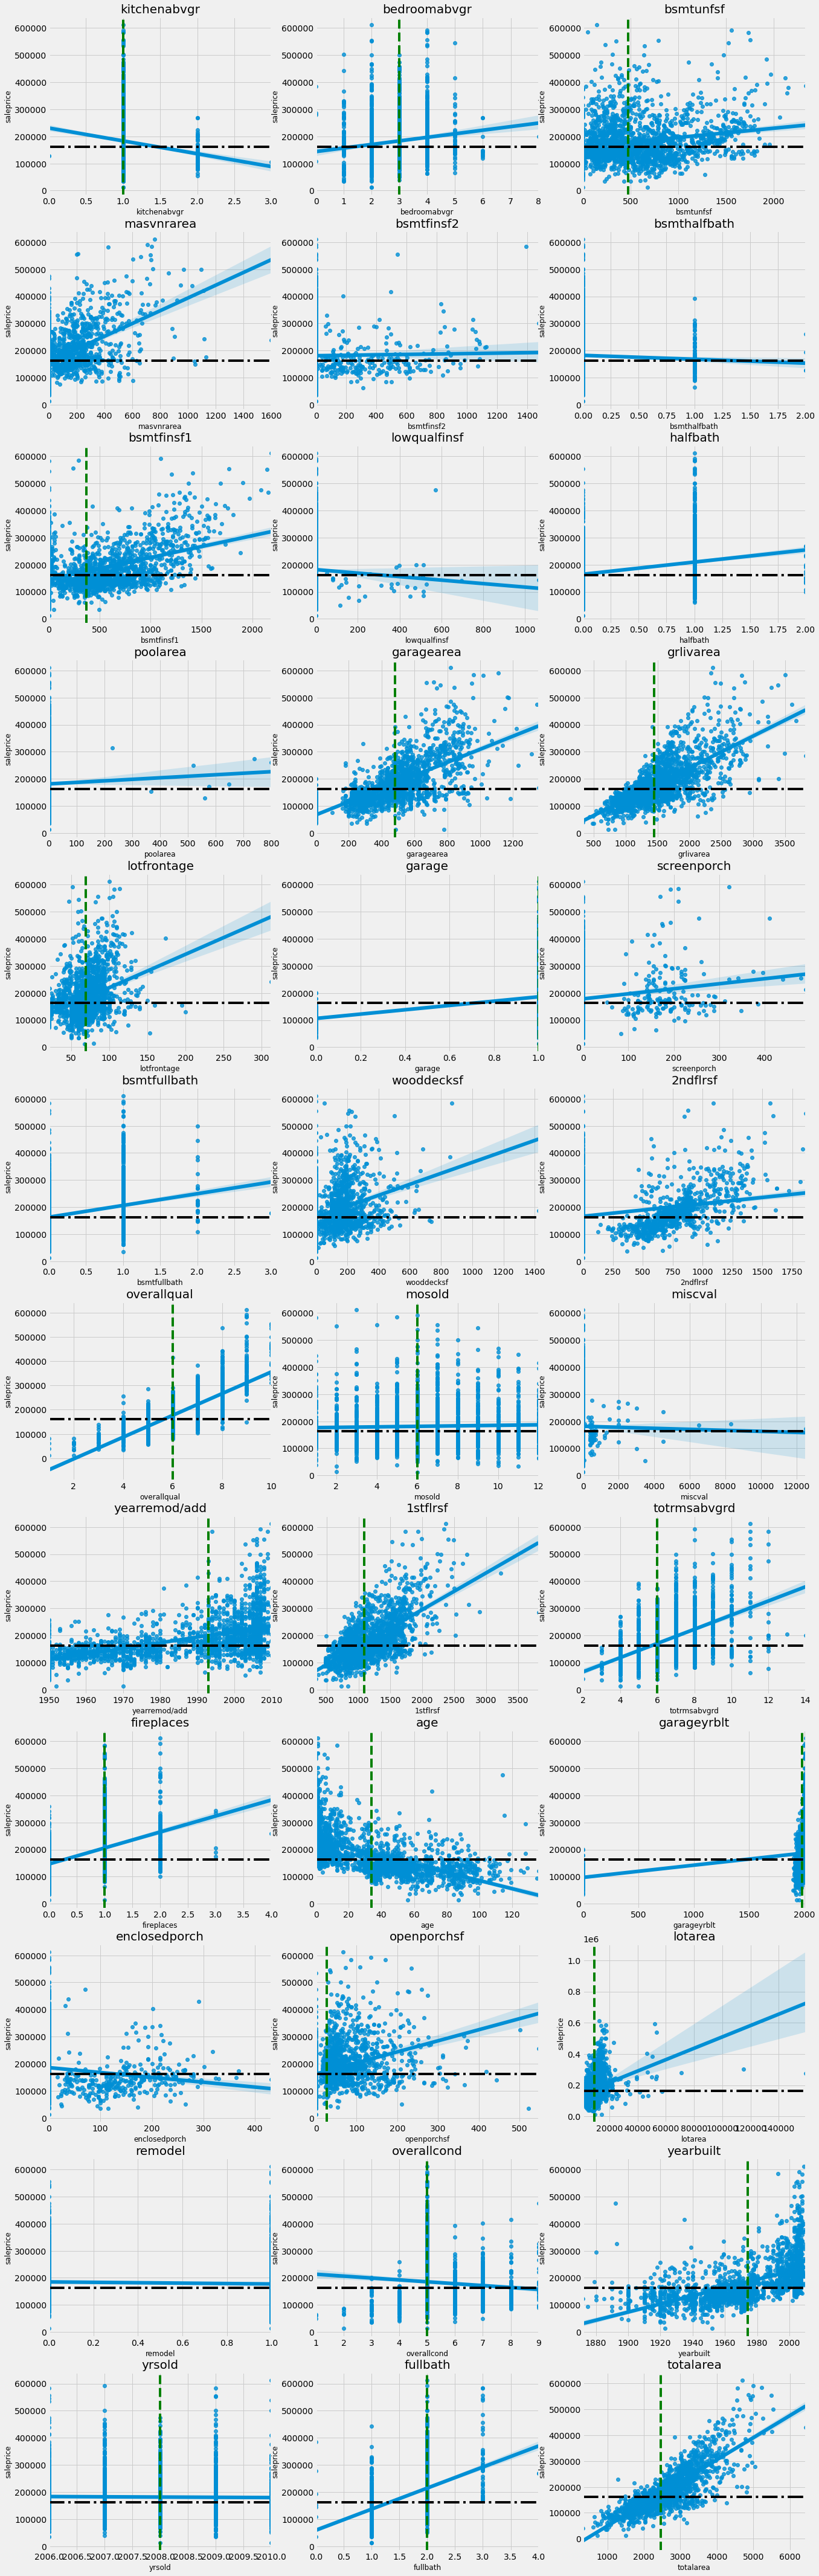

In [60]:
p = len(trn_num_col)
subplot_scatter(trn_df, 3, [ [c,'saleprice'] for c in trn_num_col ], trn_num_col, trn_num_col, ['saleprice']*p);

In [61]:
# adding saleprice back into the list for corr analysis
trn_num_col.append('saleprice') 

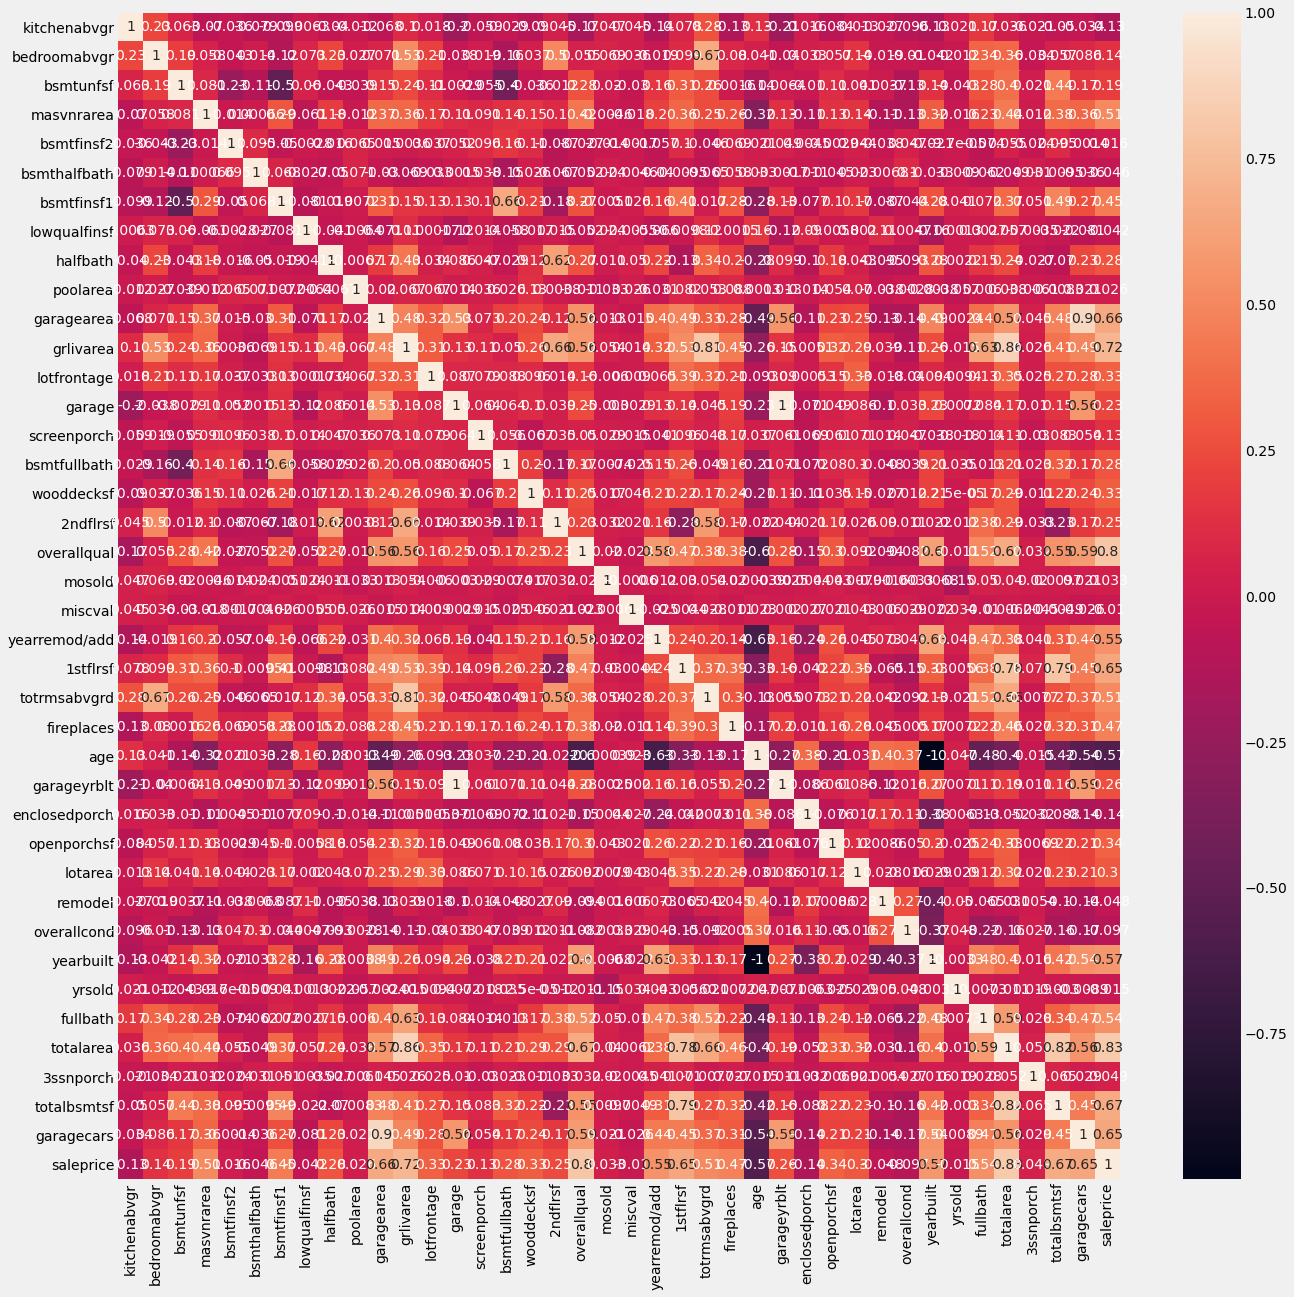

In [62]:
# plotting heatmap for the correlation
trn_corr = trn_df[trn_num_col].corr()
plt.figure(figsize=(20,20))
sns.heatmap(trn_corr, annot=True);
plt.savefig(data_files['heatmap'], dpi=400)

In [63]:
# stacking the corr into 3 columns for easy filtering
corr_df = trn_corr.stack().reset_index()
corr_df.columns = ['feat1', 'feat2', 'coef']

In [64]:
# Function to filter and display correlation by feature and percentage
def check_corr(c_df, col, cf):
    """ 
    Function to filter and display correlation by feature and percentage
  
    Parameters: 
		c_df (Dateframe): Dateframe that is holding correlation data
        col (str): features correlation to be display
        cf (str): coef lower cutoff
  
    Returns: 
		DataFrame of filtered results
  
    """
    res = c_df[(c_df['feat1']==col) & 
        (abs(c_df['coef'])>cf) & 
        (abs(c_df['coef'])<1)].sort_values(by='coef', ascending=False)
    return res

There are 10 features that are highly correlated to saleprice, these are: <br>
**totalarea** which is highly correlated to **grlivarea** and **totalbsmtsf**<br>
**overallqual** is highly correlated to **exterqual**, **bsmtqual** and **kitchenqual** <br>
**garagearea** is highly correlated to **garagecars** vice versa will drop garagecars <br>
**1stflrsf** is highly correlated to  **totalbsmtsf** 

In [65]:
# zooming into the features that have high correlation with saleprice
result = check_corr(corr_df, 'saleprice', 0.6)
result

feat1        feat2    coef
1595  saleprice    totalarea  0.8258
1578  saleprice  overallqual  0.8035
1571  saleprice    grlivarea  0.7195
1597  saleprice  totalbsmtsf  0.6651
1570  saleprice   garagearea  0.6551
1582  saleprice     1stflrsf  0.6483
1598  saleprice   garagecars  0.6482

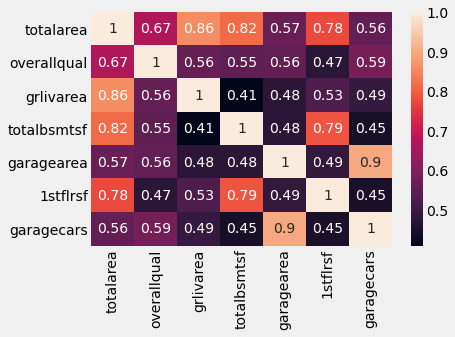

In [66]:
sns.heatmap(trn_df[result['feat2'].tolist()].corr(), annot=True);

---
#### Analysis of categorical features

In [67]:
# Function to plot a boxplot and histogram for each column
def plot_boxhist(dataframe, col, list_of_col_pairs, list_of_titles, list_of_xlabels, list_of_ylabels):
    """ 
    Function to plot a boxplot and histogram for each column. 
  
    Parameters: 
		dataframe (Dateframe): Dateframe that is holding all the data
        col (int): Number of plot per row 
        list_of_col_pairs (list): List of columns pairs that are to be plotted in the scatter plot
        list_of_titles (list): List titles for the boxplot
        list_of_xlabels (list): List of labels for the boxplot's x-axis
        list_of_ylabels (list): List of labels for the boxplot's y-axis
  
    Returns: 
		None  
  
    """
    nrows = int(np.ceil(len(list_of_col_pairs)*2/col))
    fig, ax = plt.subplots(nrows=nrows, ncols=col, figsize=(20,7*nrows)) # 6*nrows to adjust the fig according to rows
    ax = ax.ravel()
    col_color = ['steelblue', 'salmon'] # Predefine colors for plot
    
    for i, column in enumerate(list_of_col_pairs):
        c = i*2
        # boxplot
        sns.boxplot(x=column[0], y=column[1], data=dataframe, ax=ax[c])
        ax[c].set_title(list_of_titles[i], fontsize = 20)
        ax[c].set_ylabel(list_of_ylabels[i], fontsize = 12)
        ax[c].set_xlabel(list_of_xlabels[i], fontsize = 12)   
        # histogram
        t_df = dataframe[column[0]].value_counts(normalize=True).reset_index()
        t_df.columns = [column[0], 'Percent']
        sns.barplot(x=column[0], y='Percent', data=t_df, ax=ax[c+1]);
        ax[c+1].set_title(list_of_titles[i], fontsize = 20)
        ax[c+1].axhline(0.8, label="Cutoff", color='red', linewidth=1)
        for p in ax[c+1].patches:
            h = p.get_height()
            ax[c+1].text(p.get_x()+p.get_width()/2., h, '{:1.2f}'.format(h), 
                       ha="center", rotation=45) 
    return

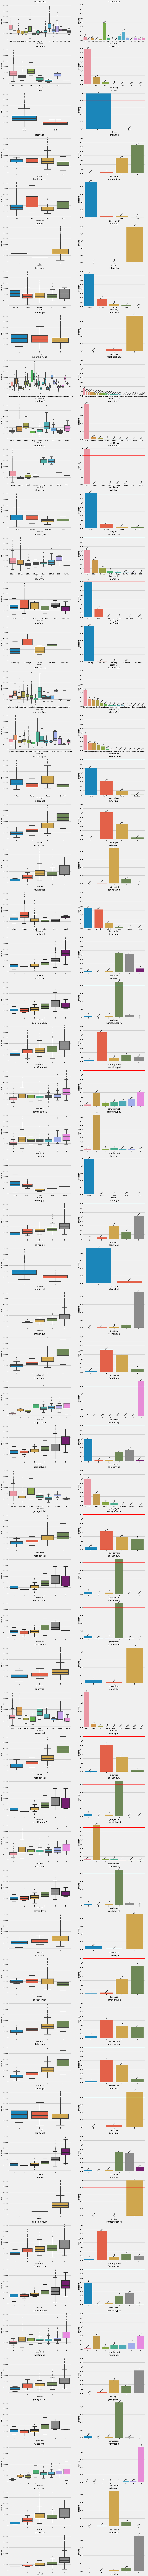

In [68]:
trn_obj_col.extend(ordinal_list)
p = len(trn_obj_col)
plot_boxhist(trn_df, 2, [ [c,'saleprice'] for c in trn_obj_col ], trn_obj_col, trn_obj_col, ['saleprice']*p);

---
#### Featrures to drop

Set a cutoff of the mode above 80% to drop the features, as plotted above.<br>
However comparing them to the boxplot, only these features below will be dropped.<br>
**utilities** 99.9% of the values are All public utilities <br>
**street** 99.7% of the values are Pave <br>
**poolarea** 99.6% of the values are 0 as there is no pool <br>
**roofmatl** 98.8% of the values are Standard (Composite) Shingle <br>
**condition2** 98.7% of the values are Norm <br>
**heating** 98.4% of the values are GasA <br>
**miscval** 96.9% of the values are 0 as there is no miscellaneous feature<br>
**landslope** 95.2% of the values are Gentle slope <br>
**centralair** 93.1% of the values are Yes <br>
**electrical** 91% of the values are Standard Circuit Breakers & Romex <br>
**paveddrive** 90.7% of the values are Paved <br>
**bsmtfintype2** 85.3% of the vales are Unfinshed <br>

**1stflrsf**, **2ndflrsf** and **lowqualfinsf** adds up into **grlivarea**<br>
**bsmtfinsf1**, **bsmtfinsf2** and **bsmtunfsf** adds up into **totalbsmtsf**<br>
**grlivarea** and **totalbsmtsf** addes up into **totalarea**<br>
**garageyrblt** has created a **garage** feature to track if there's a garage<br>
**garagecars** as this is highly correlated to **garagearea**<br>
**garagequal** as this is highly correlated to **garagecond**<br>

---

In [69]:
# List of features to drop after EDA
eda_drop_list = ['poolarea', 'utilities', '1stflrsf', '2ndflrsf', 'lowqualfinsf', 
                 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'garageyrblt', 'garagecars', 'miscval',
                 'garagequal', 'landslope', 'street', 'condition2', 'heating', 'bsmtfintype2',
                 'paveddrive', 'centralair', 'electrical', 'roofmatl', 'grlivarea', 'totalbsmtsf',
                 'yearremod/add', 'mosold', 'yrsold', 'neighborhood'
                ]
len(eda_drop_list)

27

---
#### Feature list after EDA for Model

In [70]:
# prepare list of predictors for modeling
predictors = list(set(trn_df.columns) - set(eda_drop_list))
print(f'Number of predictors after EDA: {len(predictors)}')

Number of predictors after EDA: 53


---
#### One hot encoding for catergorical variables

In [71]:
# Generate a DataFrame for modeling
trn_model_df = pd.get_dummies(trn_df[predictors].copy(), drop_first=True)
tst_model_df = pd.get_dummies(tst_df[list(set(predictors)-set(['saleprice']))].copy(), drop_first=True)

trn_model_df.head()

kitchenabvgr  bedroomabvgr  exterqual  masvnrarea  bsmthalfbath  \
Id                                                                     
109             1             3          4       289.0           0.0   
544             1             4          4       132.0           0.0   
153             1             3          3         0.0           0.0   
318             1             3          3         0.0           0.0   
255             1             3          3         0.0           0.0   

     halfbath  garagearea  lotfrontage  garage  bsmtcond  ...  \
Id                                                        ...   
109         1       475.0         57.0       1         3  ...   
544         1       559.0         43.0       1         3  ...   
153         0       246.0         68.0       1         3  ...   
318         1       400.0         73.0       1         3  ...   
255         0       484.0         82.0       1         4  ...   

     garagetype_CarPort  garagetype_Detchd  garagetype_NA  lotconfig_CulDSac  \
Id                                                                             
109                   0                  0              0                  1   
544                   0                  0              0                  1   
153                   0                  1              0                  0   
318                   0                  0              0                  0   
255                   0                  1              0                  0   

     lotconfig_FR2  lotconfig_FR3  lotconfig_Inside  landcontour_HLS  \
Id                                                                     
109              0              0                 0                0   
544              0              0                 0                0   
153              0              0                 1                0   
318              0              0                 1                0   
255              0              0                 1                0   

     landcontour_Low  landcontour_Lvl  
Id                                     
109                0                1  
544                0                1  
153                0                1  
318                0                1  
255                0                1  

[5 rows x 139 columns]

In [72]:
# Check if there are any columns is in Test but not Train
tst_dummy_cols = np.setdiff1d(tst_model_df.columns, trn_model_df.columns).tolist()
print(f'Number for columns that in Test but not Train: {len(tst_dummy_cols)}')

Number for columns that in Test but not Train: 5


In [73]:
# Dropping the dummy cols that were created in Test but not in Train data
tst_model_df = tst_model_df.drop(tst_dummy_cols, axis=1)

In [74]:
print(f"Train data's shape after one hot encoding {trn_model_df.shape}")
print(f"Test data's shape after one hot encoding {tst_model_df.shape}")

Train data's shape after one hot encoding (2049, 139)
Test data's shape after one hot encoding (879, 132)


---
## Modeling
[top](#Executive-Summary)

This section we will using Linear regression to model the data. <br>
If Linear regression is overfitted, we will proceed to use ridge and lasso regression for regularization  

#### Defining functions to be used in this section 

In [75]:
# Function to compare train and test
def model_eval_plots(m, m_name, X_tr, X_ts, y_tr, y_ts):
    """ 
    Function to compare train and test. 
  
    Parameters: 
		m (estimator): estimator object
        m_name (str): Name of the estimator
        X_tr (DataFrame): DataFrame that holds the predictors' train data
        X_ts (DataFrame): DataFrame that holds the predictors' test data
        y_tr (Series): Series that holds the predicted train data
        y_ts (Series): Series that holds the predicted test data
  
    Returns: 
		None  
  
    """
    y_train_preds = m.predict(X_tr)
    y_test_preds = m.predict(X_ts)
    
    plt.figure(figsize=(12,6))
    # Residuals
    plt.subplot(121)
    plt.scatter(y_train_preds, y_train_preds - y_tr, marker='o', label='Training data') # c='skyblue',
    plt.scatter(y_test_preds, y_test_preds - y_ts, marker='s', label='Validation data') # c='m', 
    plt.title(f'{m_name} Residuals')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=y_tr.min(), xmax=y_tr.max(), color='tomato')

    # Predictions
    plt.subplot(122)
    plt.scatter(y_train_preds, y_tr, marker='o', label='Training data') # c='skyblue', 
    plt.scatter(y_test_preds, y_ts, marker='s', label='Validation data') # c='m', 
    plt.title(f'{m_name} Predictions')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values')
    plt.legend(loc='upper left')
    plt.plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], c='tomato')
    plt.tight_layout()
    plt.show()
    
    return

In [76]:
# Function to get model's CV RMSE
def rmse_cv(model, X, y):
    """ 
    Function to get model's RMSE
  
    Parameters: 
		model (estimator): estimator objects
        X (DataFrame): DataFrame that holds the predictors' train data
        y (Series): Series that holds the predicted train data
  
    Returns: 
		rmse (float): Mean RMSE value  
    """
    return np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5).mean())

In [77]:
# Function to compile and plot the results of each estimator passed in
def model_score(m_list, m_names, X_tr, X_ts, y_tr, y_ts, plot=False, feats=None):
    """ 
    Function to compile and plot the results of each estimator passed in.
  
    Parameters: 
		m_list (list): list of estimator objects
        m_names (list): List of names of the estimator
        X_trn (DataFrame): DataFrame that holds the predictors' train data
        X_tst (DataFrame): DataFrame that holds the predictors' test data
        y_trn (Series): Series that holds the predicted train data
        y_tst (Series): Series that holds the predicted test data
  
    Returns: 
		m_eval (DataFrame): DataFrame holding the results for the estimators  
  
    """
    ss = StandardScaler()
    X_tr = ss.fit_transform(X_tr) # scale train data
    X_ts = ss.transform(X_ts) # scale test data 
    # Init a DataFrame to hold the results
    m_eval = []
    
    # Loop through the list of estimators passed in
    for i, m in enumerate(m_list):
        print(f'Fitting {m_names[i]} regression...')
        m.fit(X_tr, y_tr)
        metric = {}
        metric['Train R2'] = f'{m.score(X_tr, y_tr):,.4f}'
        metric['Test R2'] = f'{m.score(X_ts, y_ts):,.4f}'
        metric['Est Test R2'] = f'{cross_val_score(m, X_tr, y_tr, cv=5).mean():,.4f}'
        metric['Train MSE'] = f'{mean_squared_error(y_tr, m.predict(X_tr)):,.4f}'
        metric['Train Base MSE'] = f'{mean_squared_error(y_tr, [np.mean(y_tr)]*len(X_tr)):,.4f}'
        metric['Test MSE'] = f'{mean_squared_error(y_ts, m.predict(X_ts)):,.4f}'
        metric['Test Base MSE'] = f'{mean_squared_error(y_ts, [np.mean(y_ts)]*len(X_ts)):,.4f}'
        metric['Train RMSE'] = f'{rmse_cv(m, X_tr, y_tr):,.4f}'
        metric['Test RMSE'] = f'{rmse_cv(m, X_ts, y_ts):,.4f}'
        metric['alpha'] = 0 if m_names[i]=='Linear' else m.alpha_
        m_eval.append(metric)
        
        if plot:
            if m_names[i]!='Linear':
                pd.Series(m.coef_, index=feats).plot.bar(figsize=(15,7), 
                                                            title=m_names[i]+' Features');
            # Plot the train and test data
            model_eval_plots(m, m_names[i], X_tr, X_ts, y_tr, y_ts)
    m_eval = pd.DataFrame(m_eval).T
    m_eval.columns = m_names
    return m_eval

---
#### Fitting into models
First we will be doing a Linear Regression

In [78]:
# Setting up the features to be used for modeling
trn_features = trn_model_df.columns.tolist()
trn_features.remove('saleprice')
trn_features.remove('pid')
# Test data
tst_features = tst_model_df.columns.tolist()
tst_features.remove('pid')

In [79]:
# Preparation for modeling
X = trn_model_df[trn_features]
y = trn_model_df['saleprice']

# Actual Test Data's X, from here on actual test data 
# will have tst_act suffix to prevent confusion with 
# the test set created from train_test_split
X_tst_act = tst_model_df[tst_features]

In [80]:
# Splitting Train data into Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [81]:
# Keeping a copy of split data
split_data = {
    'X_train': X_train,
    'X_test' : X_test,
    'y_train': y_train,
    'y_test' : y_test
}

Instantiate Linear, Ridge and Lasso models

In [82]:
# Creating an instance of each of the models
model_list = {
    'Linear': LinearRegression(), # Create instance of `LinearRegression`
    'Ridge': RidgeCV(alphas=np.linspace(0.1, 10, 100), ), # Create an instance of `RidgeCV`
    'Lasso': LassoCV(n_alphas=100, max_iter=1000, random_state=42) # Create an instance of `LassoCV`
}

In [83]:
# dictionary to hold the features and results for each runs
model_metrics = {}

---
### Running a Linear regression on the initial 137 features

In [84]:
print(f'Starting Linear regression with {len(trn_features)} features')

Starting Linear regression with 137 features


In [85]:
# Running a Linear regression on the features
model_score([model_list['Linear']], ['Linear'], X_train, X_test, y_train, y_test)

Fitting Linear regression...


Linear
Train R2                                                 0.9106
Test R2                     -9,734,930,471,572,297,744,384.0000
Est Test R2                 -2,563,514,567,432,356,233,216.0000
Train MSE                                      560,840,191.5387
Train Base MSE                               6,272,301,458.4853
Test MSE        61,545,345,692,225,424,977,199,798,157,312.0000
Test Base MSE                                6,322,114,561.7782
Train RMSE                           3,704,356,455,567,002.0000
Test RMSE                           80,586,226,500,384,528.0000
alpha                                                         0

The metrics for Linear regression are off the charts, will have to proceed to regularization.

In [86]:
print(f"There are overblown values on both ends of the coef:")
print(f"Bottom 5-> {np.sort(model_list['Linear'].coef_)[:5]}")
print(f"Top 5->    {np.sort(model_list['Linear'].coef_)[-5:]}")

There are overblown values on both ends of the coef:
Bottom 5-> [-4.3115e+16 -4.0850e+16 -4.0850e+16 -7.7915e+03 -7.5555e+03]
Top 5->    [1.2926e+04 2.8595e+04 2.5303e+13 7.5372e+14 4.3115e+16]


---
### Running a Ridge and Lasso regression for regularization

Linear regression is not going to give any good prediction from these features. <br>
Next step is to use Ridge and Lasso to regularize the features. <br>
Have created a loop here to iterate through the Lasso coef until there are not more features with 0 coef.

In [87]:
# Looping till lasso have not features with 0 coef
for i in range(1,5):
    print(f'>>> Regularization round {i} with {len(trn_features)} features.')
    model_metrics[f'Run_{i}'] = {
                            'metrics': model_score(list(model_list.values()), 
                                                   list(model_list.keys()), 
                                                   X_train, X_test, 
                                                   y_train, y_test),
                            'features': trn_features
                        }
    # matching the coef from lasso to the features
    drop_feat = pd.DataFrame(trn_features, columns=['feature'])
    drop_feat['coef'] = model_list['Lasso'].coef_
    model_metrics[f'Run_{i}']['coef'] = drop_feat
    
    # get a list of features with lasso coef==0
    feat_to_drop = drop_feat[drop_feat['coef']==0]['feature'].tolist()
    print(f"The number of features to drop based on lasso coef: {len(feat_to_drop)}")
    
    # Stop looping when there are no more features to drop
    if len(feat_to_drop)==0:
        print(f'Stopping at round {i}')
        break
        
    # get list of columns to keep after removing those with lasso coef==0
    trn_features = np.setdiff1d(X_train.columns, feat_to_drop).tolist()
    print(f"The number of features left:{len(trn_features)}\n")
    
    # prepare X for the next run
    X_train = X_train[trn_features]
    X_test = X_test[trn_features]

>>> Regularization round 1 with 137 features.
Fitting Linear regression...
Fitting Ridge regression...
Fitting Lasso regression...
The number of features to drop based on lasso coef: 67
The number of features left:70

>>> Regularization round 2 with 70 features.
Fitting Linear regression...
Fitting Ridge regression...
Fitting Lasso regression...
The number of features to drop based on lasso coef: 0
Stopping at round 2


In [88]:
# Looking at the run 1 metrics for the 3 models
model_metrics['Run_1']['metrics']

Linear  \
Train R2                                                 0.9106   
Test R2                     -9,734,930,471,572,297,744,384.0000   
Est Test R2                 -2,563,514,567,432,356,233,216.0000   
Train MSE                                      560,840,191.5387   
Train Base MSE                               6,272,301,458.4853   
Test MSE        61,545,345,692,225,424,977,199,798,157,312.0000   
Test Base MSE                                6,322,114,561.7782   
Train RMSE                           3,704,356,455,567,002.0000   
Test RMSE                           80,586,226,500,384,528.0000   
alpha                                                         0   

                             Ridge               Lasso  
Train R2                    0.9106              0.9047  
Test R2                     0.8953              0.8997  
Est Test R2                 0.8824              0.8883  
Train MSE         560,649,367.2566    597,640,825.1640  
Train Base MSE  6,272,301,458.4853  6,272,301,458.4853  
Test MSE          661,915,265.5778    634,042,690.2588  
Test Base MSE   6,322,114,561.7782  6,322,114,561.7782  
Train RMSE             27,052.6445         26,403.2725  
Test RMSE              26,602.9165         26,262.5164  
alpha                           10                 529

In [89]:
# Looking at the run 2 metrics for the 3 models
model_metrics['Run_2']['metrics']

Linear  \
Train R2                                                0.9075   
Test R2                    -1,172,976,859,845,953,847,296.0000   
Est Test R2               -46,628,082,862,324,967,276,544.0000   
Train MSE                                     580,171,761.5457   
Train Base MSE                              6,272,301,458.4853   
Test MSE        7,415,694,086,260,958,176,807,829,372,928.0000   
Test Base MSE                               6,322,114,561.7782   
Train RMSE                         17,298,768,471,304,738.0000   
Test RMSE                          42,902,194,146,900,032.0000   
alpha                                                        0   

                             Ridge               Lasso  
Train R2                    0.9075              0.9073  
Test R2                     0.8959              0.8977  
Est Test R2                 0.8914              0.8916  
Train MSE         580,342,855.3581    581,405,969.9140  
Train Base MSE  6,272,301,458.4853  6,272,301,458.4853  
Test MSE          658,318,524.2780    646,956,361.2326  
Test Base MSE   6,322,114,561.7782  6,322,114,561.7782  
Train RMSE             25,996.7000         25,976.0525  
Test RMSE              25,659.1895         25,525.7086  
alpha                           10               140.5

Looking at both the metrics, Lasso regression is performing slightly better than Ridge.
After going through 2 rounds of Lasso regression, we are down to 70 features from 137.

---
### Generate prediction from 70 features 
Will use Lasso to generate a prediction from this 70 features and check the RMSE score in Kaggel

In [90]:
# Check if there are any columns is in Features but not actual Test data
tst_cols = np.setdiff1d(trn_features, tst_features).tolist()
print(f'Number for columns that in Features but not Test: {len(tst_cols)}')

Number for columns that in Features but not Test: 0


In [91]:
# make sure that the model is fitted with the correct features
X_train = X_train[trn_features]
X_test = X_test[trn_features]

Fitting Lasso regression...


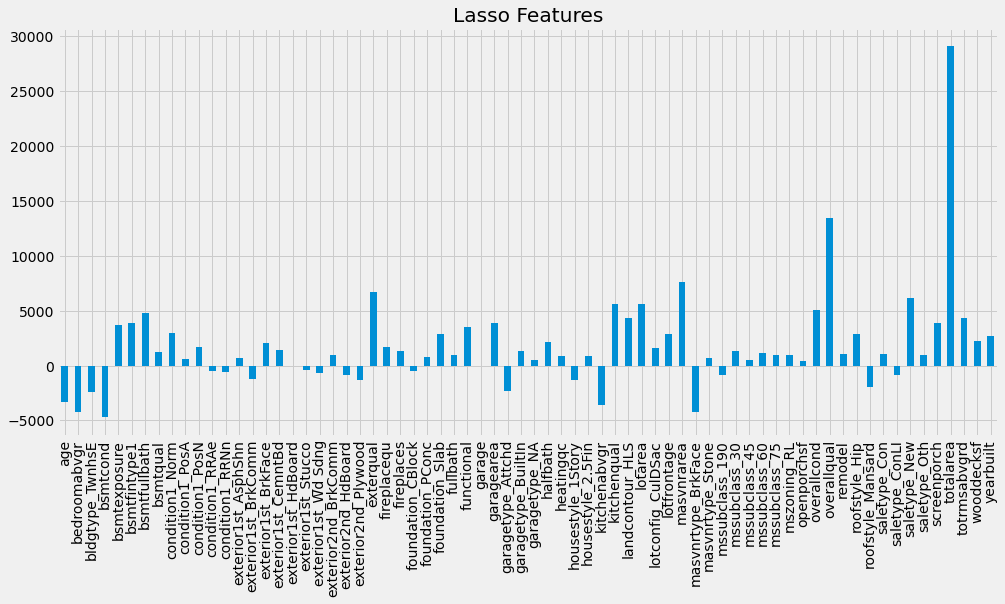

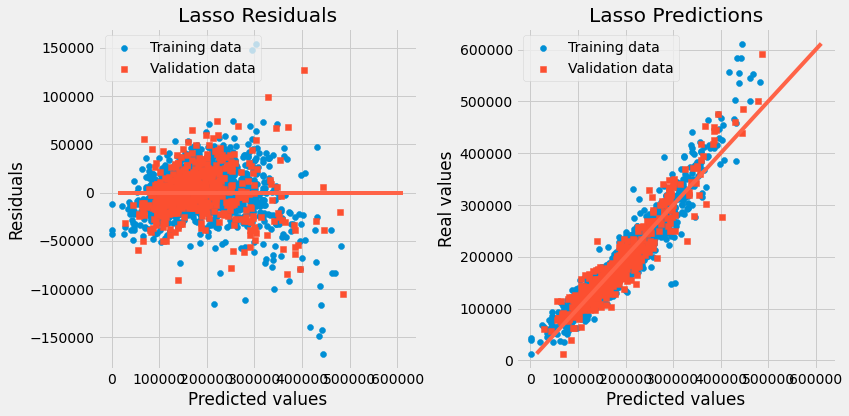

In [92]:
# fitting the model and ploting the results
model_metrics['70_feats'] = {
                            'metrics': model_score([model_list['Lasso']], ['Lasso'], 
                                                   X_train, X_test, 
                                                   y_train, y_test, True, trn_features),
                            'features': trn_features
                        }

In [93]:
# Lasso metrics for 70 features
model_metrics['70_feats']['metrics']

Lasso
Train R2                    0.9073
Test R2                     0.8977
Est Test R2                 0.8916
Train MSE         581,405,969.9140
Train Base MSE  6,272,301,458.4853
Test MSE          646,956,361.2326
Test Base MSE   6,322,114,561.7782
Train RMSE             25,976.0525
Test RMSE              25,525.7086
alpha                        140.5

In [94]:
# Saving the coef dataframe into the model metrics
model_metrics['70_feats']['coef'] = pd.DataFrame({
        'feature' : trn_features,
        'coef' : model_list['Lasso'].coef_
})

In [95]:
# Fitting StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train) # scale train data

In [96]:
# Scaling actual Test data from Kaggle
X_tst_act = tst_model_df[trn_features]
X_tst_act_scaled = ss.transform(X_tst_act) # scale actual test data

In [97]:
# Get prediction for Test data
y_pred = model_list['Lasso'].predict(X_tst_act_scaled)

In [98]:
# Generate Kaggle submission file
submission = pd.DataFrame({
        "Id": tst_model_df.index,
        "SalePrice": y_pred
    })
submission.to_csv(data_files['submit'], index=False)

Kaggle score for 70 features: **30152.22860**

---
### Using RFE to narrow down to 30 features
Next we try using **RFE** to reduce the features to a more managable size of 30

In [99]:
# Create the RFE model and select 30 attributes
rfe = RFE(model_list['Lasso'], n_features_to_select=30)
rfe = rfe.fit(X_train, y_train)
# summarize all features
rfe_features = []
for i in range(X_train.shape[1]):
    feature = {
        'feature': trn_features[i],
        'selected': rfe.support_[i],
        'rank': rfe.ranking_[i]
    }
    rfe_features.append(feature)

In [100]:
# convert the RFE selected features to a list
rfe_df = pd.DataFrame(rfe_features)
rfe_features = rfe_df[rfe_df['selected']]['feature'].tolist()

In [101]:
# Check if there are any features in RFE features but not Test
rem_cols = np.setdiff1d(rfe_features, tst_features).tolist()
print(f'Number for columns that in Features but not Test: {len(rem_cols)}')
print(f'The columns are: {rem_cols}')

Number for columns that in Features but not Test: 0
The columns are: []


In [102]:
rfe_features = list(set(rfe_features)-set(rem_cols))
print(f'Number of columns after dropping the {len(rem_cols)} that was not in Test: {len(rfe_features)}')

Number of columns after dropping the 0 that was not in Test: 30


In [103]:
# prepare X for the next run
X_train = X_train[rfe_features]
X_test = X_test[rfe_features]

Fitting Lasso regression...


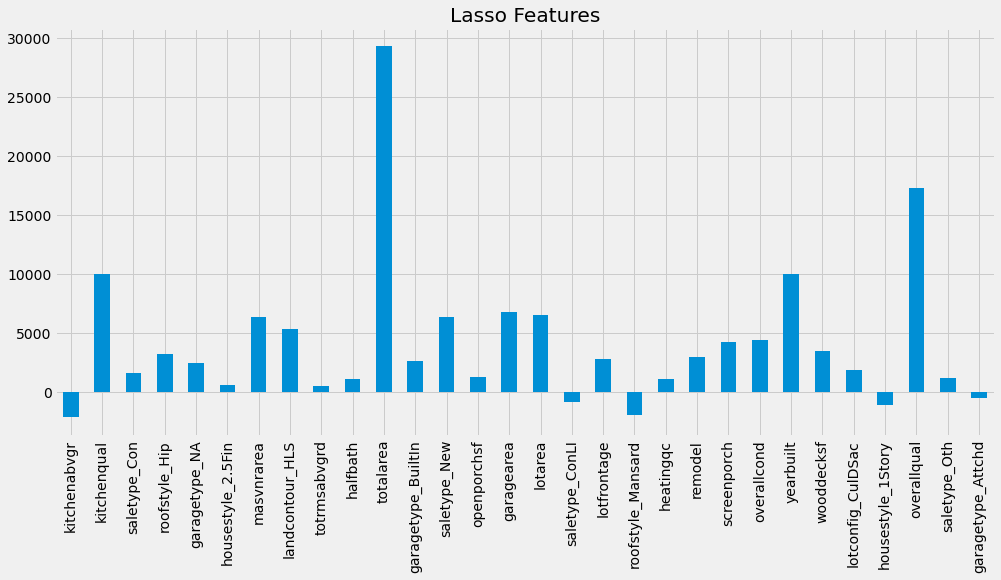

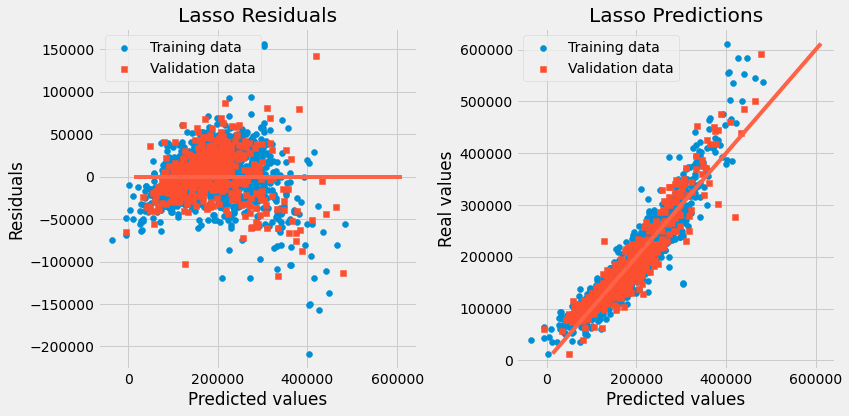

In [104]:
# fitting the model and ploting the results
model_metrics['30_RFE'] = {
                            'metrics': model_score([model_list['Lasso']], ['Lasso'], 
                                                   X_train, X_test, 
                                                   y_train, y_test, True, rfe_features),
                            'features': rfe_features
                        }

In [105]:
# Lasso metrics for 30 features
model_metrics['30_RFE']['metrics']

Lasso
Train R2                    0.8771
Test R2                     0.8752
Est Test R2                 0.8664
Train MSE         770,896,674.1042
Train Base MSE  6,272,301,458.4853
Test MSE          789,053,995.1445
Test Base MSE   6,322,114,561.7782
Train RMSE             28,911.5555
Test RMSE              28,273.6632
alpha                        199.2

In [106]:
X_train_scaled = ss.fit_transform(X_train) # scale train data

In [107]:
# Actual Test data from Kaggle
X_tst_act = tst_model_df[rfe_features]
X_tst_act_scaled = ss.transform(X_tst_act) # scale actual test data

In [108]:
# Get prediction for Test data
y_pred = model_list['Lasso'].predict(X_tst_act_scaled)

In [109]:
# Generate Kaggle submission file
submission = pd.DataFrame({
        "Id": tst_model_df.index,
        "SalePrice": y_pred
    })
submission.to_csv(data_files['submit'], index=False)

Kaggle score for RFE 30 features: **33383.66286** <br>
RFE's feature selection doens't seem to fair too well with unknown data. 

---
### Manual selection of features
Since RFE is not returning a set of features that is doing well on unknown data. <br>
Will do a manual selection of the features.

In [110]:
la_coef = model_metrics['70_feats']['coef']

In [111]:
la_coef.sort_values(by='coef')

feature        coef
3             bsmtcond  -4718.8613
1         bedroomabvgr  -4259.6427
47  masvnrtype_BrkFace  -4217.1517
40        kitchenabvgr  -3571.5705
0                  age  -3314.5029
..                 ...         ...
63        saletype_New   6171.7137
23           exterqual   6738.5302
46          masvnrarea   7640.8914
57         overallqual  13425.3490
66           totalarea  29071.3848

[70 rows x 2 columns]

In [112]:
# Pick the top and bottom 15 features
final_features = la_coef.sort_values(by='coef').head(15)['feature'].tolist()
final_features.extend(la_coef.sort_values(by='coef').tail(15)['feature'].tolist())
print(f"The number of features left:{len(final_features)}")

The number of features left:30


In [113]:
# prepare X for the next run
X_train = split_data['X_train'][final_features]
X_test = split_data['X_test'][final_features]

Fitting Linear regression...


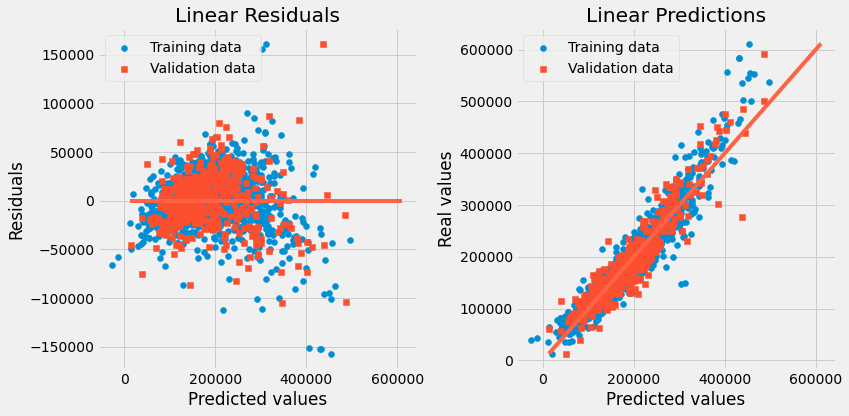

Fitting Ridge regression...


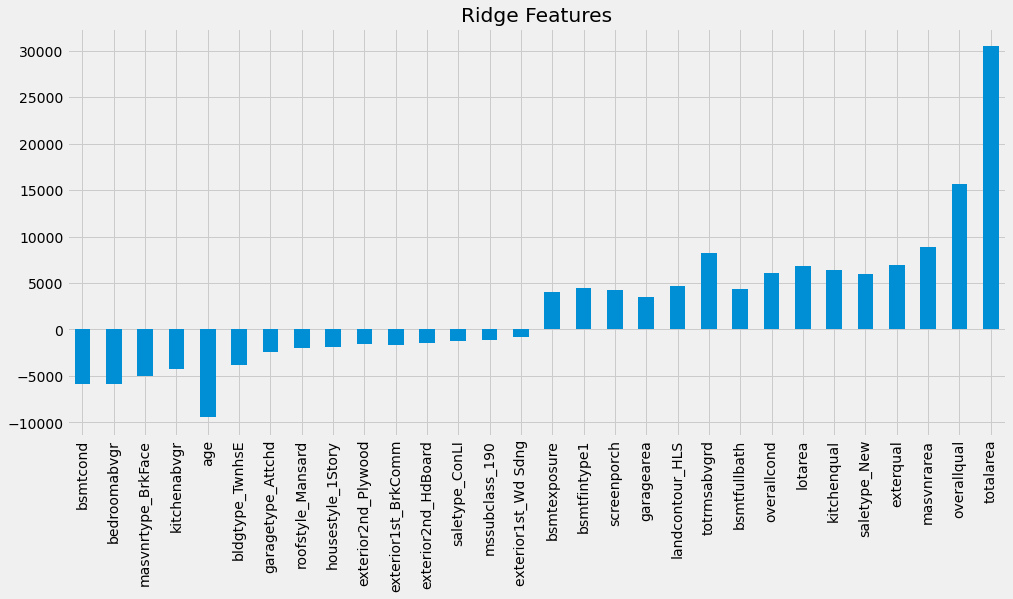

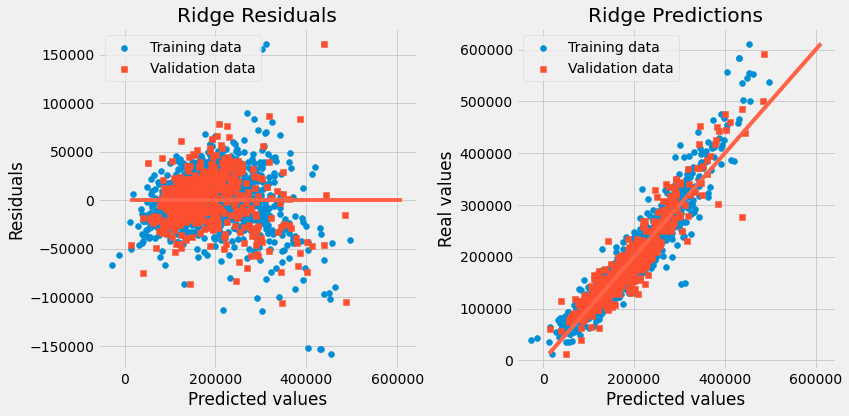

Fitting Lasso regression...


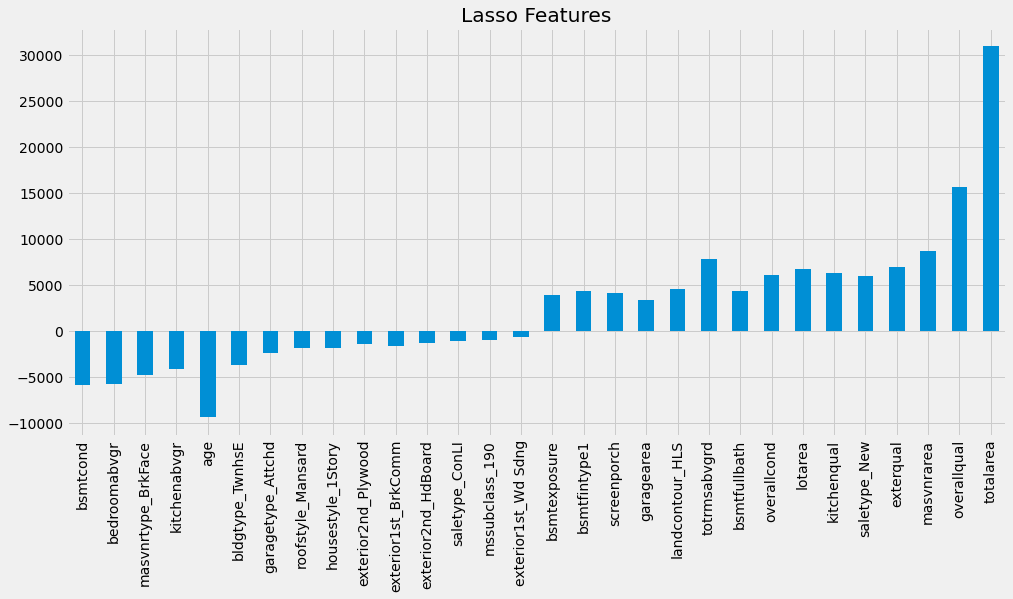

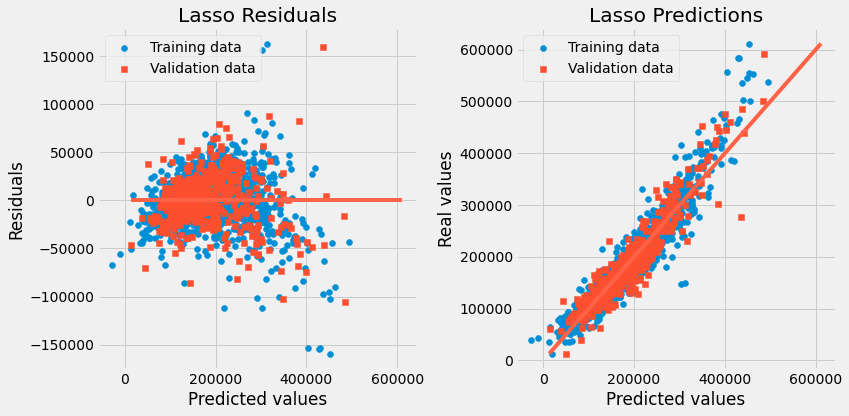

In [114]:
model_metrics[f'30_feats'] = {
                            'metrics': model_score(list(model_list.values()), 
                                                   list(model_list.keys()),
                                                   X_train, X_test, 
                                                   y_train, y_test, True, final_features),
                            'features': final_features
                        }

### Metrics for final features

In [115]:
model_metrics['30_feats']['metrics']

Linear               Ridge               Lasso
Train R2                    0.8941              0.8941              0.8940
Test R2                     0.8820              0.8820              0.8833
Est Test R2                 0.8465              0.8825              0.8826
Train MSE         664,321,343.7111    664,471,268.9340    664,693,531.8503
Train Base MSE  6,272,301,458.4853  6,272,301,458.4853  6,272,301,458.4853
Test MSE          745,730,263.3517    746,122,692.5622    737,817,172.2124
Test Base MSE   6,322,114,561.7782  6,322,114,561.7782  6,322,114,561.7782
Train RMSE             31,750.0061         26,986.0859         26,982.6437
Test RMSE              26,335.5186         26,402.1912         26,398.5640
alpha                            0                  10               106.3

In [116]:
final_coef = pd.DataFrame({
        'feature' : final_features,
        'coef' : model_list['Lasso'].coef_
})

In [117]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train) # scale train data

In [118]:
# Actual Test data from Kaggle
X_tst_act = tst_model_df[final_features]
X_tst_act_scaled = ss.transform(X_tst_act) # scale actual test data

In [119]:
# Get prediction for Test data
y_pred = model_list['Lasso'].predict(X_tst_act_scaled)

In [120]:
# Generate Kaggle submission file
submission = pd.DataFrame({
        "Id": tst_model_df.index,
        "SalePrice": y_pred
    })

submission.to_csv(data_files['submit'], index=False)

Kaggle score for manual selection of 30 features: **31766.14795** <br>
Manual selected list of feature performed better than the RFE list, but against 70 features it was slightly worst off. 

---
---
## Conclusions
[top](#Executive-Summary)



In terms of feature list, it'll be the manual selection list of 30 features. <br>
Although it performed sligthy worst off than 70 features, manual selection score of 31766.14795 vs 30152.22860. <br>
Would still go ahead with 30 features, as it will be easier to manage a smaller set of features in terms of time and effort. <br> And still be able to meet the problem statement's target of RMSE of ~30k.<br>
Looking at the [metrics](#Metrics-for-final-features) for the manual selection list, all the 3 models linear, ridge and lasso scores are very close. <br> However the final pick will be Lasso as it's RMSE is sligthly better than the other 2.

In [121]:
# Top 5 negative coef features
final_coef.sort_values(by='coef').head()

feature       coef
4                 age -9381.1292
0            bsmtcond -5857.0228
1        bedroomabvgr -5774.5376
2  masvnrtype_BrkFace -4826.2247
3        kitchenabvgr -4158.6533

In [122]:
# Top 5 positive coef features
final_coef.sort_values(by='coef').tail()

feature        coef
26     exterqual   6993.0413
20  totrmsabvgrd   7812.0639
27    masvnrarea   8687.1493
28   overallqual  15697.7521
29     totalarea  30968.5664

Looking at the top positive and negative coef features, we can conclude that: <br>
Age has a highly negative impact on the price, which makes sense as the newer houses will fetch a better price.<br>
On the other end totalarea which is sum of GrLivArea and TotalBsmtSF, has the greatest positive impact to the saleprice.  
Followed by overall quality, Masonry veneer area, Total rooms above grade and external quality. <br>Therefore it will be beneficial for homeowner to maintain the overall and external quality of the house, if they want to sell at a higher price.

Overall this model may perform reasonally well with it's current features, however this model may not generalize well in other cities. <br>
As other cities may have more appartments type of buildings and proximity to malls or schools may be valued. <br>
For those cities more data would be required, for example which floor the appartment is at, facing of the appartment, carpark availability. Well that will be for another Kaggle contest :)